# Fidelity Susceptibility For 1D TFIM
## 1D TFIM
- The transverse field Ising model (TFIM) on a 1-dimensional lattice have the Hamiltonian:
$$
H = - \sum_{i=0}^{N-1} \left( g\sigma_i^x + \sigma_i^z \sigma_{i+1}^z \right)
$$
- Where g is a non-negtive parameter, have to do with the strength of the transverse magnetic field.

## Fidelity Susceptibility
- Fidelity susceptibility is used as an indicator for quantum phase transition (QPT), when the system is 
experiencing a QPT, the calculated fidelity susceptibility $\chi_F$ would be significantly large.
- From **quantum fidelity**, $F$:
$$
F(g, \epsilon) = \left| \left< \psi_0(g) | \psi_0(g+\epsilon) \right> \right|
$$
- We have **fidelity susceptibility**, $\chi_F$ as:
$$
\chi_{F}=-\left.\frac{\partial^{2} \ln F(g, \varepsilon)}{\partial \varepsilon^{2}}\right|_{\varepsilon=0}
$$
- To make implementation more conveniently, we could transform it into another form:
$$
\chi_{F}=-\left.\frac{\partial^{2}}{\partial g^{\prime 2}} \ln \left|\left\langle\psi_{0}(g) \mid \psi_{0}\left(g^{\prime}\right)\right\rangle\right|\right|_{g^{\prime}=g}
$$
- Note here the partial derivative is only applied to one of the two ground states.

# Implementation Guide
- In this notebook, the automatic-differentiation (AD)is used to compute the second order derivative of the log product of the overlap of two ground state wave functions.
- AD could be significantly powerful if we could define function primitives properly, and it gives a general paradigm for solving even higher order derivatives.
- In this notebook, the AD package **JAX** is used to customize derivative rules for function primitives, and to perform the automatic differentiation.

# Jax Support
- Import **JAX** packages
- And other support packages

In [1]:
import jax.numpy as jnp
from jax import  grad,lax
from jax.config import config
from jax import custom_vjp
from functools import partial
import numpy as np

config.update("jax_enable_x64", True)

# TFIM Model Initialization
- Initialize the TFIM model with the Hamiltonian shown above.
- Note here only matrix product
$$
H \cdot v
$$
- is needed

In [2]:
def H_u_initialize(N):
    """
    Input:  'N': the number of sites of TFIM model
    Output: 'H_u': a function that returns H*u
            'Hadjoint_to_gadjoint': the translation function
                    to calculate gadjoint form
                    Hadjoint
    """
    dim = 2**N

    #initialize the diagnal of the hamiltonian matrix
    diag_index = jnp.arange(dim)[:, jnp.newaxis]
    diag_bin_reps = (diag_index >> jnp.arange(N)[::-1]) & 1
    diag_spins = 1 - 2 * diag_bin_reps
    diag_spins_prime = jnp.hstack((diag_spins[:,1:],diag_spins[:,0:1]))
    diag_elements = -(diag_spins * diag_spins_prime).sum(axis=1)

    #initialize the basis of flips
    flip_masks = jnp.array([1 << i for i in range(N)], dtype="int64")
    flip_basis = jnp.arange(dim)[:,None]
    flips_basis = flip_basis ^ flip_masks

    #first derivative of H, in a vector product form
    def pHpg(v):
        result_pHpg = -v[flips_basis].sum(axis=1)
        return result_pHpg

    #defining the product function H
    def H_u(g,u):
        """
        recieving the parameter g for TFIM model
        and a vector u
        then construct the Hamiltonian H,
        return the product of H and u:H*u
        """
        result_H_u = u * diag_elements - g * u[flips_basis].sum(axis=1)
        return result_H_u
    
    def Hadjoint_to_gadjoint(v1,v2):
        """
        the adjoint translation function to be 
        used in CG and symeig function

        Input: 'v1': one required vector to calculate A
                'v2': another vector to calculate A
                then A = v1 * v2^T(outer product)
        Output: 'g_adjoint': the adjoint of the parameters(g)
                    with respect to A
        """

        return jnp.matmul(pHpg(v2),v1)  #Here must ensure a scalar output
        
    
    return H_u, Hadjoint_to_gadjoint

# Lanczos Implementation
- Here the Lanczos algorithm is used for eigensolver in the future.(see https://en.wikipedia.org/wiki/Lanczos_algorithm)

## Lanczos Algorithm

In [3]:
def Lanczos(g,A, k, *, sparse=True, dim=None):
    """
    Lanczos method to help solve the eigenvalue
    and eigenvector of a real symmetrix matrix.

    Input:  'g': The parameter for TFIM model
            'A': The n times n real symmetrix matrix.
            'k': The number of Lanczos vectors requested.
            'sparse': If sparse = True, means the matrix
                    input A is in a linear function representation
                    form.
            'dim':  If sparse = True, then the integer param 'dim'
                    should be given, indicating the dimension
                    of the square matrix A

    Output: A tuple (Q_k, T): Q_k = (q_1 q_2 ... q_k) is a n*k matrix, 
            whose columns contain k orthomormal Lanczos vectors q1, q2, ..., qk.
            T is the tridiagonal matrix of size k, satisfying Qk^T * Q_k = I_k,
            and T has the same eigenvalue with matrix A, and the eigenvector
            of A could be drawn from the eigenvector of T.( let eigenvector of T
            be x, then y=Q_k*x is the eigenvector of A)
    """
    if sparse == True:
        n = dim
        dtype = jnp.float64
        Amap = A
    else:
        raise NotImplementedError("In this programm must use sparse mode")
            
    Q_k = jnp.zeros((n,k), dtype=dtype)
    alphas = jnp.zeros(k, dtype=dtype)
    betas = jnp.zeros(k - 1, dtype=dtype)
    q = jnp.array(np.random.randn(n).astype(dtype))
    q /= jnp.linalg.norm(q)
    u = Amap(g,q)
    alpha = jnp.matmul(q,u)
    Q_k = Q_k.at[:, 0].set(q)
    alphas = alphas.at[0].set(alpha)
    beta = 0
    qprime = jnp.array(np.random.randn(n).astype(dtype))
    for i in range(1,k):
        r = u - alpha * q - beta * qprime

        #Reorthogonalization
        r -= jnp.matmul(Q_k[:, :i], jnp.matmul(Q_k[:, :i].T, r))

        qprime = q
        beta = jnp.linalg.norm(r)
        q = r / beta
        u = Amap(g,q)
        alpha = jnp.matmul(q,u)
        alphas = alphas.at[i].set(alpha)
        betas = betas.at[i-1].set(beta)
        Q_k = Q_k.at[:, i].set(q)
    #param k in jnp.diag indicates which diagonal to consider
    T = jnp.diag(alphas) + jnp.diag(betas, k=1) + jnp.diag(betas, k=-1)
    return Q_k, T

## Eigensolver for symmetric matrix with Lanczos
- Computes the extreme eigenvalues and eigenvectors
    upon request of a symmetric matrix A with Lanczos
    algorithm implemented.

In [4]:
def symeigLanczos(g,A, k, extreme="both", *,
                    sparse=True, dim=None):
    """
        Computes the extreme eigenvalues and eigenvectors
    upon request of a symmetric matrix A with Lanczos
    algorithm implemented.

    Input: 'g': The parameter for TFIM model 
        'A': The n times n real symmetrix matrix.
        'k': The number of Lanczos vectors requested.
        'sparse': If sparse = True, means the matrix
                input A is in a linear function representation
                form.
        'dim':  If sparse = True, then the integer param 'dim'
                should be given, indicating the dimension
                of the square matrix A
        'extreme':  labels the desired eigenvalues and 
                corresponding eigenvectors to be returned.
                Specificlly,
                "both" -> both min and max.     --Output--> (eigval_min, eigvector_min, eigval_max, eigvector_max)
                "min" -> min.                   --Output--> (eigval_min, eigvector_min)
                "max" -> max.                   --Output--> (eigval_max, eigvector_max)
    Output: See "Input" above.
    """
    Q_k, T = Lanczos(g,A, k, sparse=sparse, dim=dim)
    eigvalsQ, eigvectorsQ = jnp.linalg.eigh(T,UPLO='U')
    eigvectorsQ = jnp.matmul(Q_k,eigvectorsQ)
    if extreme == "both":
        return eigvalsQ[0], eigvectorsQ[:, 0], eigvalsQ[-1], eigvectorsQ[:, -1]
    elif extreme == "min":
        return eigvalsQ[0], eigvectorsQ[:, 0]
    elif extreme == "max":
        return eigvalsQ[-1], eigvectorsQ[:, -1]

# CG Implementation
- Conjugate Gradient(CG) method is used to solve linear system as $A \vec{x} = \vec{b}$

## CG Linear System Solver

In [5]:
def CG_Algorithm(g,A, b, initial_x, sparse=True):
    """
    Solve for x in linear equation Ax=b
    with an initial choose of x, initial_x.
    Note here A is a matrix and x and b are vectors.
    Using Conjugate Gradient(CG) method.

    Input:  'g': The parameter for TFIM model 
        'A': The real symmetric and positive definite
            matrix A.
        'b': The vector corresponding to the equation Ax=b
        'initial_x': The initial vector of the CG algorithm.
        `sparse`: If sparse = True, means the matrix
                input A is in a linear function representation
                form. In any cases, the dimension of A is 
                inferred from the size of the vector b.
    Output:
        'x': the solution for Ax=b
    """
    if sparse == True:
        Amap = A
    else:
        raise NotImplementedError("In this programm must use sparse mode")
    n = b.shape[0]
    epsilon = 1e-7
    x = initial_x
    r = b - Amap(g,x)

    if(np.linalg.norm(r) < epsilon):
        return x

    d = r
    alpha = np.matmul(r, r) / np.matmul(Amap(g,d),d)

    for i in range(n):
        x = x + alpha * d
        r_next = r - alpha * Amap(g,d)
        if(np.linalg.norm(r_next) < epsilon):
            break
        beta = np.matmul(r_next,r_next) / np.matmul(r,r)
        r = r_next
        d = r + beta * d
        alpha = np.matmul(r,r) / np.matmul(Amap(g,d), d)
    
    return x

## CG function primitive
- CG function primitive, here ``custom_vjp`` is used to customize the behavior of the back-propagation of the gradients. Reference:https://buwantaiji.github.io/2019/10/CG-backward/

In [6]:
@partial(custom_vjp, nondiff_argnums=(0,1,))
def CGSubspaceSparse(Aadjoint_to_gadjoint, A, g, E_0, b, alpha):
    """
    Function primitive for low-rank CG linear
    system solver, here A is 'sparse',
    hence in a function representation,
    which is a linear transformation that
    takes a vector as input and returns another
    vector (A*v) as output.
    Input:  'Aadjoint_to_gadjoint': The function that
        recieves the adjoint of A and returns the
        adjoint of the depending parameter g. Note
        here 'Aadjoint_to_gadjoint' is a python callable.
            'A': a linear transformation form of matrix A
            'g': The depending parameter that determines matrix A.
            'E_0': smallest eigvalue
            'b': The vector satisfying (A - E_0I)x = b
            'alpha': The unique eigenvector of A w.r.t. E_0
    Output: the unique solution x of the low-rank 
            linear system (A - E_0I)x = b in addition to
            the condition alpha^T x = 0.
    """
    Aprime = lambda g,v: A(g,v) - E_0 * v
    initial_x = jnp.array(np.random.randn(b.shape[0]).astype(b.dtype))
    initial_x = initial_x - jnp.matmul(alpha,initial_x) * alpha
    x = CG_Algorithm(g,Aprime,b,initial_x,sparse=True)
    return x

def CGSubspaceSparse_fwd(Aadjoint_to_gadjoint, A, g, E_0, b, alpha):
    x = CGSubspaceSparse(Aadjoint_to_gadjoint,A,g,E_0,b,alpha)
    res = (g, E_0, alpha,x)
    return x, res

def CGSubspaceSparse_bwd(Aadjoint_to_gadjoint,A,res, grad_x):
    g, E_0, alpha,x = res
    b = grad_x - jnp.matmul(alpha, grad_x) * alpha
    grad_b = CGSubspaceSparse(Aadjoint_to_gadjoint, A, g, E_0, b, alpha)
    v_1, v_2 = - grad_b, x
    grad_alpha = -x * jnp.matmul(alpha, grad_x)
    grad_E_0 = -jnp.matmul(v_1, v_2)
    grad_g = Aadjoint_to_gadjoint(v_1, v_2)
    return (grad_g,grad_E_0,grad_b,grad_alpha)

CGSubspaceSparse.defvjp(CGSubspaceSparse_fwd,CGSubspaceSparse_bwd)

# Dominant Eigensolver primitive for symmetric matrix
- Dominant eigensolver function primitive, also customized with ``costum_vjp``, and here the function recieves the input A as a normal matrix (but not a spare representation).

In [7]:
@partial(custom_vjp, nondiff_argnums=(0,1,))
def DominantSparseSymeig(Aadjoint_to_gadjoint, A, g, k, dim):
    """
    Function primitive for dominant real symmetric
    eigensolver,note here A is 'sparse',
    hence in a function representation,
    which is a linear transformation that
    takes a vector as input and returns another
    vector (A*v) as output.
    Input:  'Aadjoint_to_gadjoint': The function that
        recieves the adjoint of A and returns the
        adjoint of the depending parameter g. Note
        here 'Aadjoint_to_gadjoint' is a python callable.
            'A': a linear transformation form of matrix A
            'g': The depending parameter that determines matrix A.
            'k': number of requested Lanczos vectors
            'dim': The dimension of the square matrix A.
    Output: 'eigval': the smallest eigenvalue of A
            'eigvector':corresponding (non-degenerate)
                    eigenvector
    """
    eigval, eigvector = symeigLanczos(g,A,k,extreme="min", sparse=True, dim=dim)
    return (eigval, eigvector)

def DominantSparseSymeig_fwd(Aadjoint_to_gadjoint, A, g, k, dim):
    eigval, eigvector = DominantSparseSymeig(Aadjoint_to_gadjoint, A, g, k, dim)
    res = (g, eigval, eigvector)
    return (eigval, eigvector), res

def DominantSparseSymeig_bwd(Aadjoint_to_gadjoint,A,res, grads):
    grad_eigval, grad_eigvector = grads
    g, eigval, eigvector = res
    b = grad_eigvector - jnp.matmul(eigvector, grad_eigvector) * eigvector
    lambda_0 = CGSubspaceSparse(Aadjoint_to_gadjoint, A, g, eigval, b, eigvector)
    grad_A = grad_eigval * eigvector - lambda_0, eigvector
    v_1, v_2 = grad_A
    grad_g = Aadjoint_to_gadjoint(v_1,v_2)
    grad_k = grad_dim = None
    return (grad_g, grad_k,grad_dim)

DominantSparseSymeig.defvjp(DominantSparseSymeig_fwd,DominantSparseSymeig_bwd)

# Compute the Fidelity Susceptibility
- To compute the fidelity susceptibility, the function ``from_g_to_logproduct`` is defined, then second order derivative is executed on this function, with respect to $\psi(g')$

In [8]:
def from_g_to_logproduct_sparse(g, N, k):
    """
    Computing logproduct using DominantSymeig in symeig.py,
    which is to perform AD with direct matrix form.

    Input:  'g': parameter in TFIM
            'g_no_diff': parameter in TFIM from which the
                computed psi_0 will not be applied
                to AD, have the same value with 'g'
            'N': number of sites
            'k': number of Lanczos vectors
    Output: 'log_product': the log product of the two
                ground state wave funciton:
                ln( < psi_0(g) | psi_0(g') > )
                Here the AD is only applied to |psi(g')>
    """

    H_u, Hadjoint_to_gadjoint = H_u_initialize(N)
    dim = 2**N
    energy_0, psi_0 = DominantSparseSymeig(Hadjoint_to_gadjoint ,H_u,g,k,dim)
    psi_matmul = jnp.matmul(lax.stop_gradient(psi_0),psi_0)
    log_product = jnp.log(psi_matmul)
    return log_product


def fid_sus_sparse_repre(g,N,k):
    """
        Computing fidelity susceptibility using DominantSparseSymeig in symeig.py,
    which is to perform AD with sparse representation of matrix A.
    """
    dlogdg = grad(from_g_to_logproduct_sparse,argnums=0)
    d2logdg = grad(dlogdg,argnums=0)(g,N,k)
    fid_sus = - d2logdg
    return fid_sus

- Here the parameters of the model is defined, and the calculation is run in a loop.

 Completed.

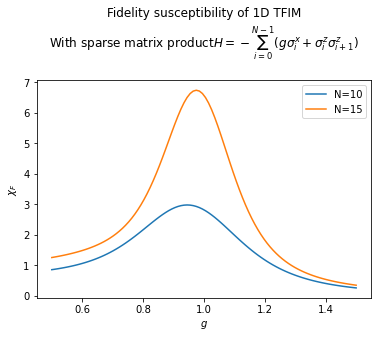

In [9]:
N = 10
N_2 = 15
# N_3 = 20
k = 300
g_count = 100
gs = np.linspace(0.5, 1.5, num = g_count)
fid_sus_from_sparse_repre = np.empty(g_count)
fid_sus_from_sparse_repre_2 = np.empty(g_count)
fid_sus_from_sparse_repre_3 = np.empty(g_count)

for i in range(g_count):
    fid_sus_from_sparse_repre[i] = fid_sus_sparse_repre(gs[i], N, k)
    fid_sus_from_sparse_repre_2[i] = fid_sus_sparse_repre(gs[i], N_2, k)
    # fid_sus_from_sparse_repre_3[i] = fid_sus_sparse_repre(gs[i], N_3, k)
    print(f"\r g={gs[i]}",end="", flush=True)

print("\r Completed.",end="", flush=True)
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(gs, fid_sus_from_sparse_repre, label = f"N={N}")
ax.plot(gs, fid_sus_from_sparse_repre_2, label = f"N={N_2}")
# ax.plot(gs, fid_sus_from_sparse_repre_3, label = f"N={N_3}")
ax.set_xlabel(r"$g$")
ax.set_ylabel(r"$\chi_F$")
ax.set_title("Fidelity susceptibility of 1D TFIM\n" 
             "With sparse matrix product"
        r"$H = - \sum_{i=0}^{N-1} (g\sigma_i^x + \sigma_i^z \sigma_{i+1}^z)$" "\n")
ax.legend()
plt.show()